# OpenAI CLIP

作者: 爱睡觉的KKY

CLIP全称Constrastive Language-Image Pre-training，顾名思义是采用对比学习的文本-图像预训练模型。CLIP惊艳之处在于架构非常简洁且效果好到难以置信，在zero-shot文本-图像检索，zero-shot图像分类，文本→图像生成任务guidance，open-domain 检测分割等任务上均有非常惊艳的表现。本文将对CLIP的模型，训练过程进行介绍，并使用openAI-CLIP预训练权重看看实际效果。

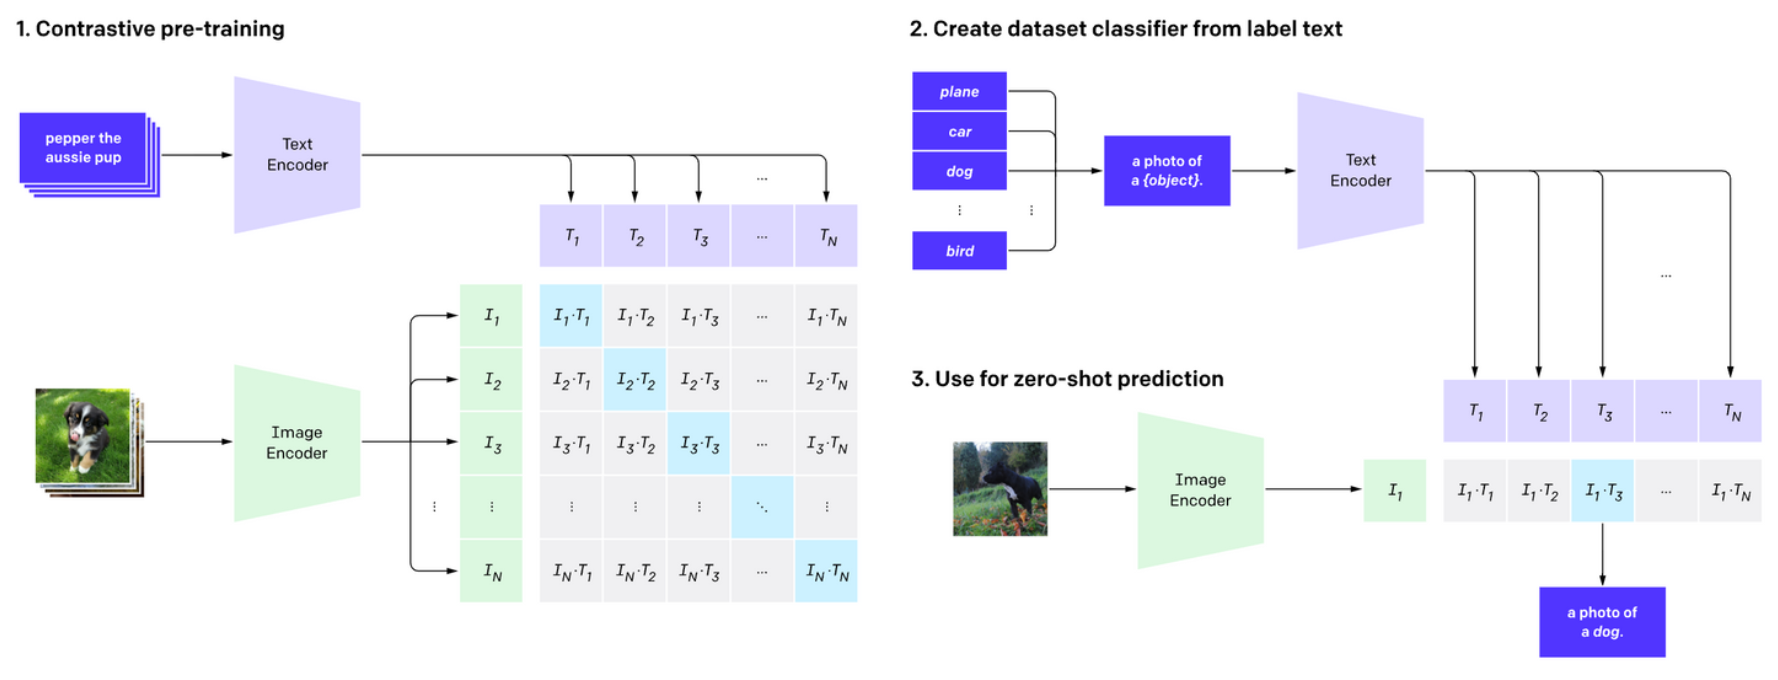

## 模型详解

### 1. 数据准备

数据采用如下图所示的text-image pairs，文本是图片相关的描述信息。

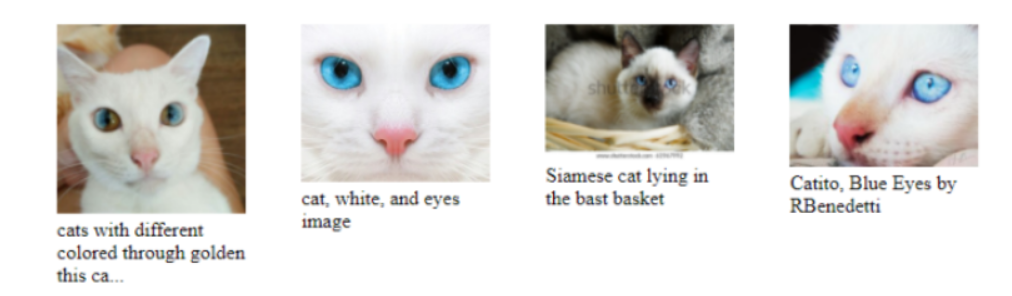

### 2. 训练过程伪代码

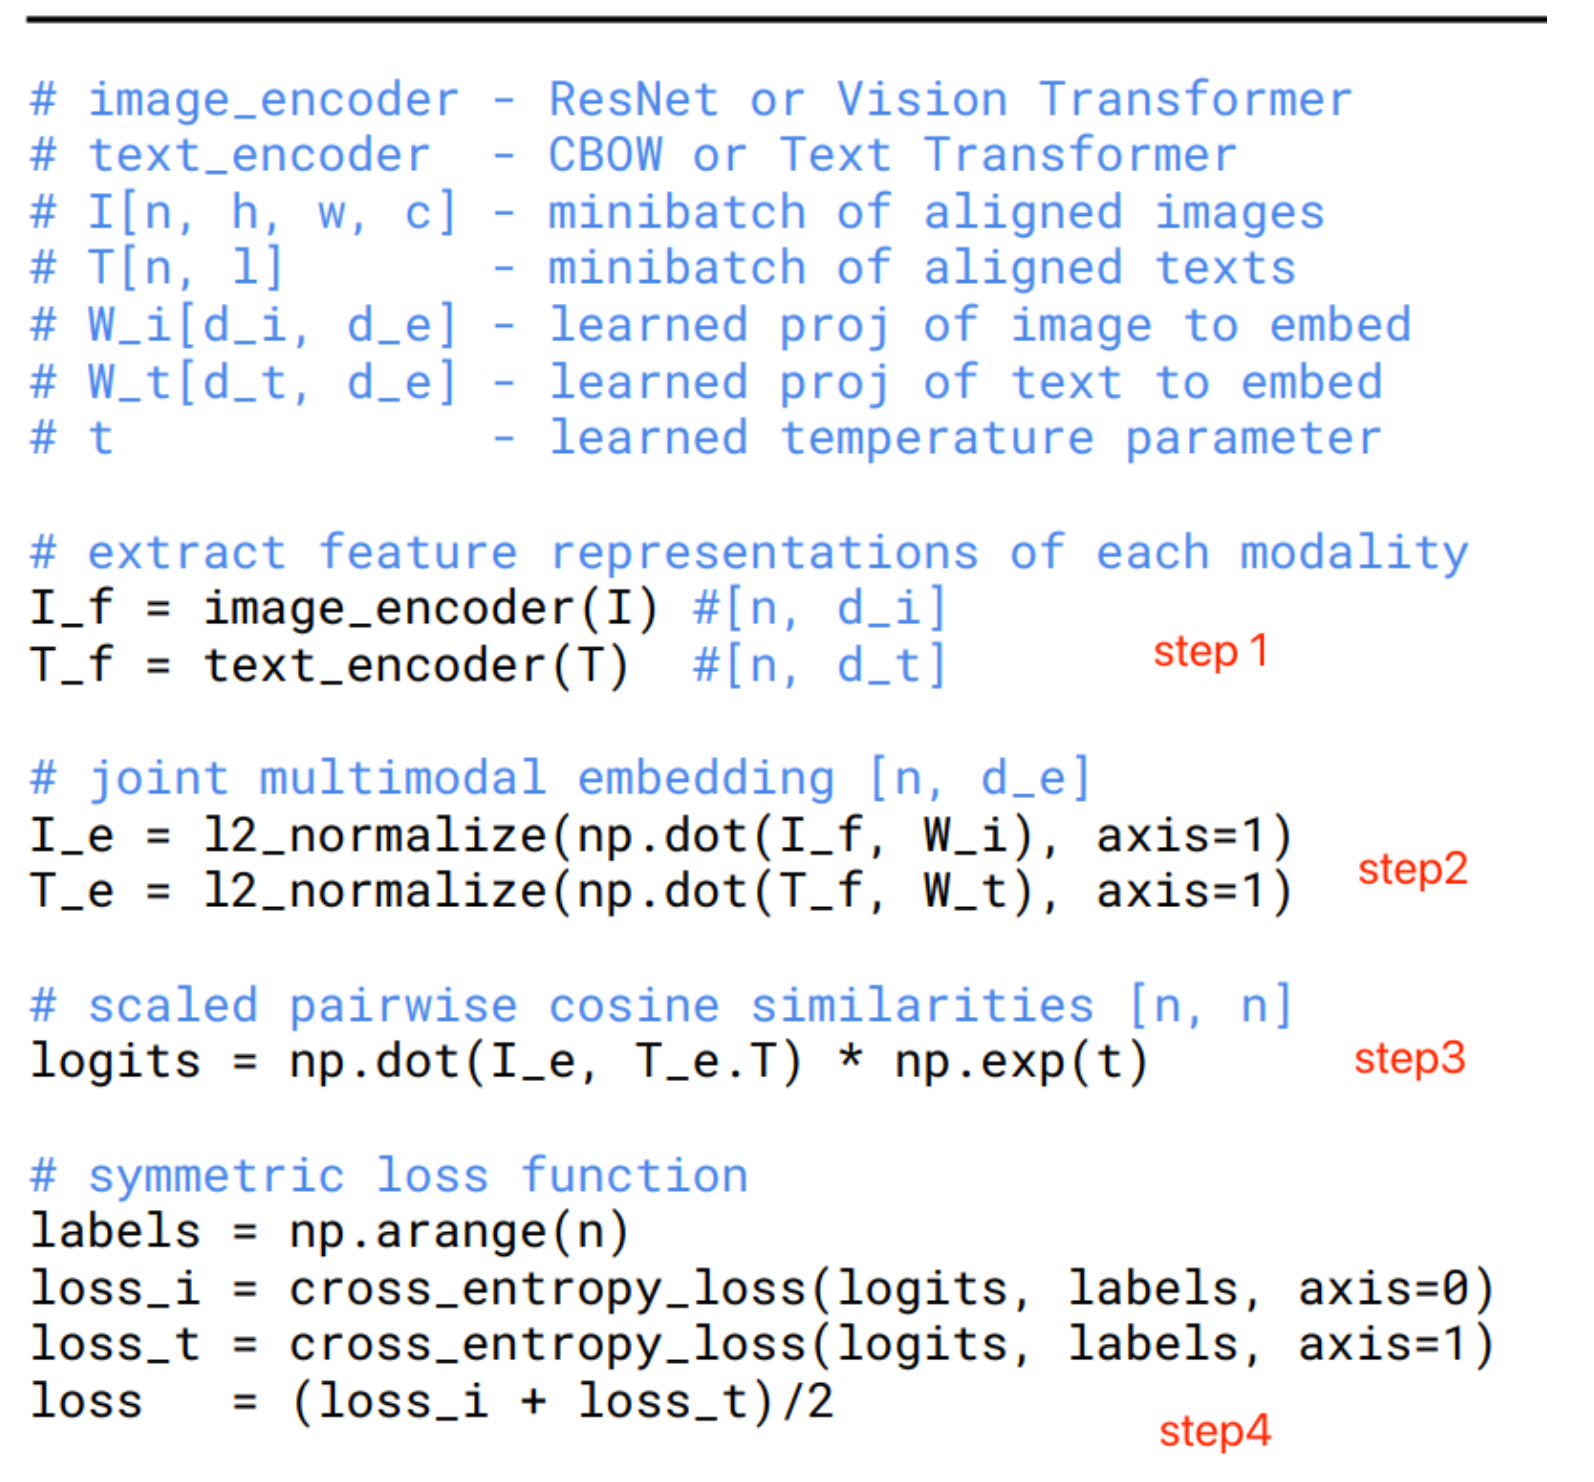

**定义**

- 论文中采用的两种文本编码器：CBOW或者Text Transformer（BERT family model）
- 论文中采用的两种图像编码器：ResNet和Vision Transformer （ViT）
- 定义了两个投影矩阵W_i和W_t，用于将文本及图像特征映射到相同维度大小。
- temperature参数用于控制softmax后的结果，temperature < 1 时模型倾向于给出更加极端的预测值（more confidence)，temperture > 1 的时候模型预测值在更接近0.5 (less confidence)

**step 1 : 编码** 

通过图像&文本编码器，得分图像和文本特征。

**step2 : 投影**

首先通过投影矩阵将图像及文本特征映射到相同的维度大小，在进行L2 normalization （使得之后的点积操作直接等效于cosine similarity)

**step3: 相似度计算**

点积运算计算文本-图像的cosine similarity，得到 n x n 矩阵的logits（模型预测），越接近1则说明模型预测该文本-图像对是配对的，否则不配对。

**step4: 计算loss**

已知 logits 矩阵对角线的文本和图像是配对的，非对角线元素不配对，因此构造训练标签 np.arange(n)，然后分别在图像维度（axis=0) 和文本维度（axis=1)计算loss。以图像维度为例简单说明一下这里的逻辑，因为在计算相似度的时候，图像特征矩阵@文本特征矩阵得到的 n x n 矩阵，第一个n 代表的图像，因此我们在axis=0 计算图像维度的loss。

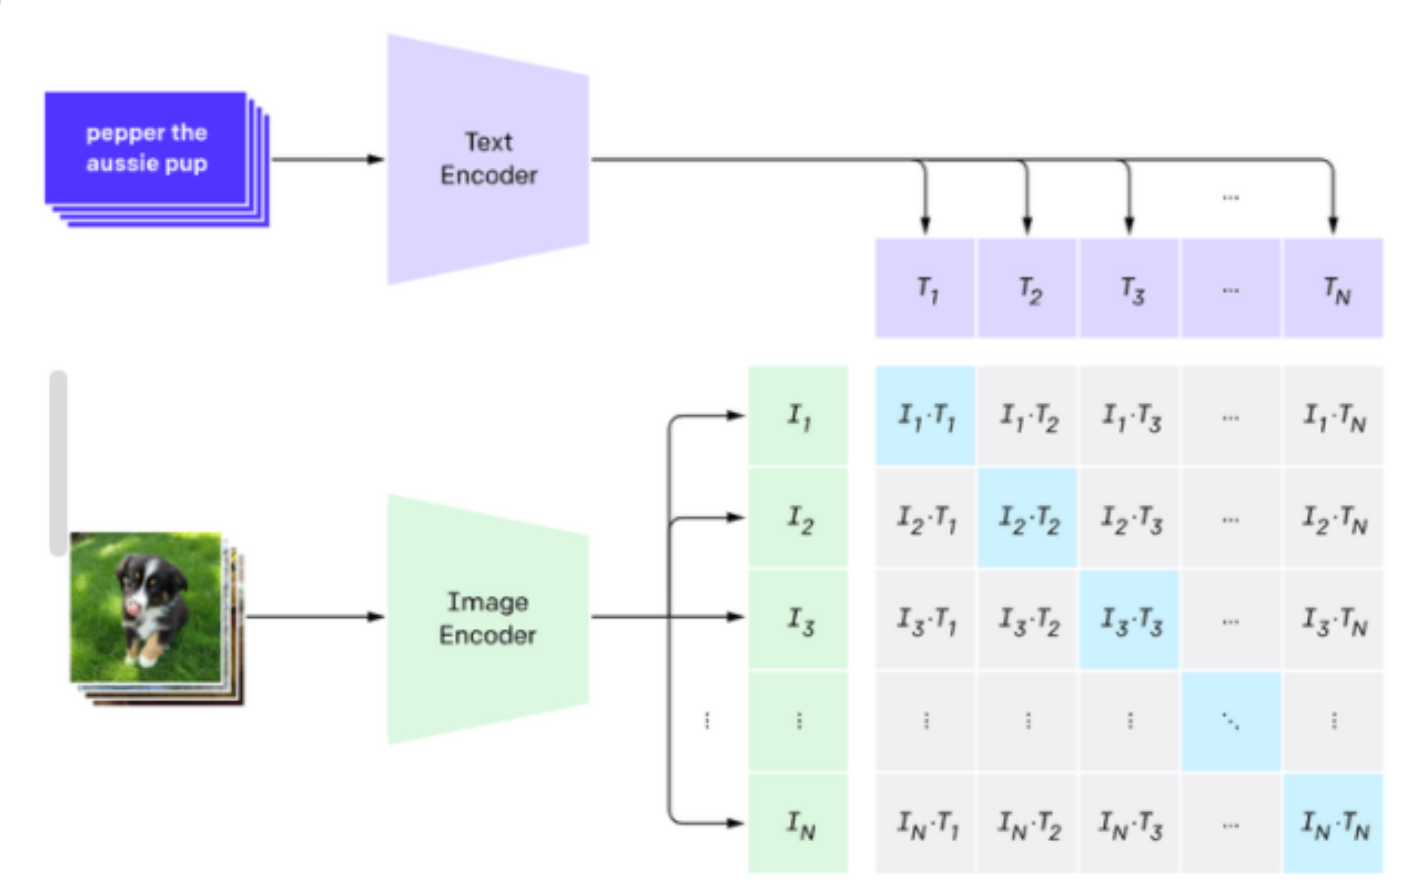

到这里，关于CLIP模型及训练基本了解下，下面来看看CLIP可以做哪些应用？

## 模型下游应用

CLIP可以将文本和图像表征映射到同一个表示空间，那么很多有趣的事情就可以操作了：

1. Zero-Shot图像分类：计算图像(1)与prompt后的分类标签(n)的相似度，找到相似度最高的标签
2. Zero-Shot图像检索：查询文本向量(1)和待检索图像(n)计算相似度，找到相似度最高的图片
3. CLIP Guidence Generation，通过文本引导生成图像任务中，使用CLIP模型计算生成图像与引导文本的距离，得到更加符合语义的生成结果。（e.g. VQGAN+CLIP)
4. CLIP Condition Generation，在文本生成图像任务中，使用CLIP text encoder 将文本编码向量做为输入，直接进行图像生成。（e.g. stable diffusion)
5. open-domain 检测、分割，甚至是zero-shot open domain 分割任务均可以胜任

## CLIP实践

需要提前配置一下环境，如果已经有PyTorch环境，可以不用执行第一行安装命令。如果在第三行安装过程中遇到网络问题，可以在Kaggle kernel或其他云服务器尝试。

```shell
$ conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
$ pip install ftfy regex tqdm
$ pip install git+https://github.com/openai/CLIP.git
```

In [1]:
import numpy as np

In [2]:
import torch
import clip
from PIL import Image
import requests
import matplotlib.pyplot as plt

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
# 这里如果你没有手动下载权重，把model_name_or_path改为 ViT-B-32即可
model_name_or_path = "/data/GUIE/clip/ViT-B-32.pt"
model, preprocess = clip.load(model_name_or_path, device=device)

定义两个函数，分别进行图片与文本的编码，图片文本均需要预处理：
1. 对于文本采用类似`huggingface/transformers`的tokenizer，这里已经在`CLIP`中集成了，只需要进行调用`tokenize`方法即可
2. 对于图像，`CLIP`预处理模型采用`torchvision`，默认支持`PIL.Image`输入

In [3]:
from PIL import Image
import requests

# im = Image.open(requests.get(url, stream=True).raw)

In [4]:
def load_img(path=None, url=None):
    if path is not None: img = Image.open(path)
    if url is not None: img = Image.open(requests.get(url, stream=True).raw)
    return img.resize((224, 224))


@torch.no_grad()
def encode_text(text):
    tokens = clip.tokenize([text]).to(device)
    text_features = model.encode_text(tokens)
    return text_features


@torch.no_grad()
def encode_image(path=None, url=None):
    img = load_img(path=path, url=url)
    img_pt = preprocess(img).unsqueeze(0).to(device)
    image_features = model.encode_image(img_pt)
    return image_features

def find_most_similar(text, img_urls):
    text_emb = encode_text(text)
    imgs_emb = torch.cat([encode_image(url=img) for img in img_urls], dim=0)
    
    sim_mat = text_emb @ imgs_emb.T
    find = np.argmax(sim_mat[0].cpu().numpy()) + 1
    print(sim_mat)
    print(f"Awnswer is {find}")

然后我们在网上找几张图片玩耍一下...

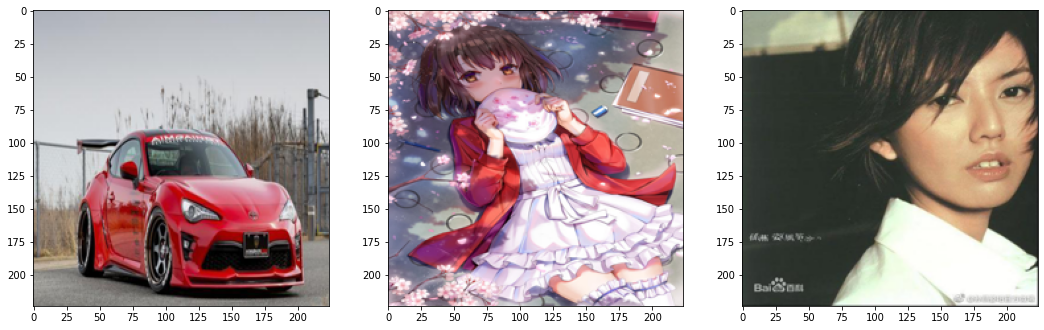

In [5]:
car = "https://img2.baidu.com/it/u=3312196097,3387995773&fm=253&fmt=auto&app=138&f=JPEG?w=640&h=363"
hui = "https://p2.bahamut.com.tw/HOME/creationCover/14/0003634414_B.JPG"
yanzi = "https://img1.baidu.com/it/u=4192874553,1854958147&fm=253&fmt=auto&app=120&f=JPEG?w=500&h=543"

f, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(np.array(load_img(url=car)))
ax[1].imshow(np.array(load_img(url=hui)))
ax[2].imshow(np.array(load_img(url=yanzi)))

搜索红色汽车，返回最相似的图片第一章，正确～！

In [6]:
find_most_similar("red car", [car, hui, yanzi])

tensor([[23.2812, 20.5781, 18.0156]], device='cuda:0', dtype=torch.float16)
Awnswer is 1


我们来定义一些文本（找圣人惠 lol），来看看相似度结果是否符合预期。

In [7]:
# 日文: 冴えない彼女の育てかた
# 中文: 路人女主的养成方法
# En: Saekano: How to Raise a Boring Girlfriend

find_most_similar("Saekano: How to Raise a Boring Girlfriend", [car, hui, yanzi])

tensor([[ 4.7031, 19.7344,  8.7812]], device='cuda:0', dtype=torch.float16)
Awnswer is 2


wow，找到了。笑）而且相似度给的很高。也许这个描述太简单的，换一个问法：红色衣服白色短裙的卡通女孩

In [8]:
find_most_similar("cartoon girl with red dress and white skirt", [car, hui, yanzi])

tensor([[ 8.8906, 20.2656, 12.5000]], device='cuda:0', dtype=torch.float16)
Awnswer is 2


对于CLIP来说依然毫无难度啊...

### 训练CLIP

OpenAI官方是给了训练代码的，但是自己实现也非常简单！还可以加深对模型的理解，训练数据&代码可以参考这篇文章：https://www.kaggle.com/code/moeinshariatnia/openai-clip-simple-implementation

## Refs

- [https://openai.com/blog/clip/](https://openai.com/blog/clip/)
- [https://www.kaggle.com/competitions/google-universal-image-embedding/discussion/353768](https://www.kaggle.com/competitions/google-universal-image-embedding/discussion/353768)